# Titanic - ML

Задание с  платформы Kaggle https://www.kaggle.com/competitions/titanic/overview Нашей целью будет обучить модель, которая сможет предсказывать выжил ли пассажир Титаника исходя из известных нам данных. В качетсве метрики качества будет использоваться accuracy.

В ходе проекта нам необходимо будет изучить и подготовить данные, обучить несколько моделей машинного обучения, подобрать к ним гиперпараметры, выбрать лучшую и проверить её на тестовой выборке.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import copy

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool

from sklearn.metrics import accuracy_score, plot_roc_curve, roc_curve

from tqdm import notebook 
from tqdm.notebook import tqdm

## Предварительный анализ данных

В данном разделе откроем и изучим данные, построим ряд диаграмм, чтобы посмотреть как распределены наши данные.

In [2]:
data = pd.read_csv('train.csv')
display(data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


В тренировочном датасете 891 строк, в некоторых из них есть пропуски. Посмотрим количество пропусков в каждом столбце.

In [4]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Больше всего пропусков в столбце с номером каюты. Вероятнее всего от него придётся избавиться. Также есть пропуски в столбце с возрастом и с портом посадки, эти пропуски необходимо будет как-то обработать. Выведем отдельно информацию по числовым и категориальным признакам

In [5]:
data.describe(include='number')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


По числовым данным от столбца 'PassengerId' необходимо будет избавиться - он не несёт информативной нагрузки и использовать его в дальнейшем обучении не получится. Данные в остальных столбцах выглядят правдоподобно. 

In [6]:
data.describe(exclude='number')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


По категориальным признакам все имена уникальные, в графе пол всего два значения. Данные по билетам и каютам необходимо будет удалить. В столбце порт посадке есть 3 уникальных порта C = Cherbourg, Q = Queenstown, S = Southampton.

Изучим целевой признак Survived. Выедем информацию по уникалным значениям

In [7]:
data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Данные в этом столбце принимают только 2 значения, соответственно мы имеет дело с задачей классификации. Целевой признак немного несбалансирован и это нужно будет учесть в ходе обучения моделей

Выведем информацию о проценте выживаемости в целом по датасету

In [8]:
data['Survived'].mean()

0.3838383838383838

Изучим влияют ли пропуски в столбцах на процент выживаемости. Начнём с возраста

In [9]:
data[data['Age'].isna()]['Survived'].mean()

0.2937853107344633

Как видно из полученных данных при отсутсвии информации о возрасте пассажира выживаемссть становиться ниже средней на 10 процентов. В дальнейшем создадим соответствующий столбце, где выведем данную информацию.

В столбце Embarked всего 2 пропуска, поэтому его анализировать не эффективно, любые зависимости в нём могут быть случайными. Рассмотрим столбец с каютами.

In [10]:
data[data['Cabin'].isna()]['Survived'].mean()

0.29985443959243085

Отсутсвие информации в данном столбце также влияет на выживаемость, поэтому его мы тоже закодируем.

Рассмотрим данные по классу каюты, выведем уникальные значения в данном столбце и потом сгруппируем данные по ним.

In [11]:
data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [12]:
data.pivot_table(index='Pclass', values='Survived', aggfunc=['count','mean'])

,count,mean
,Survived,Survived
Pclass,,
1,216,0.629630
2,184,0.472826
3,491,0.242363


Для большей наглядности построим диаграмму распределения пассажиров по классу

Text(0, 0.5, 'Количество пассжиров')

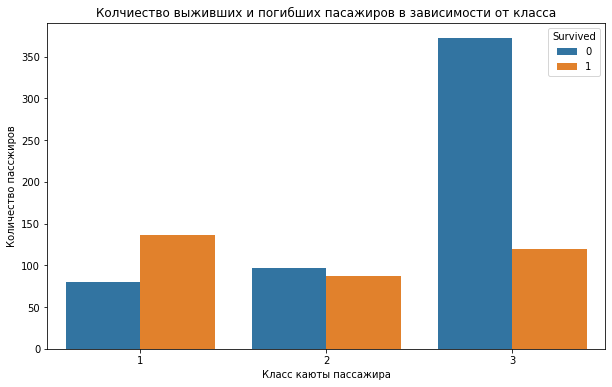

In [13]:
plt.figure(figsize=(10,6))
plt.title('Колчиество выживших и погибших пасажиров в зависимости от класса')

bar = sns.barplot(data=data.pivot_table(index=['Pclass','Survived'], values='PassengerId', aggfunc='count').reset_index(drop=False), 
                   x='Pclass', 
                   y='PassengerId', 
                   hue='Survived')

bar.set_xlabel('Класс каюты пассажира')
bar.set_ylabel('Количество пассжиров')

В исходных данных всего 3 класса. Больше всего путешественников было пассажирами 3 класа, при этом среди них был самый низкий процент выживших на борту.

Изучим влияние пола пассажира на процент выживаемости. Сначала отдельно, потом с учётом класса пассажира.

In [14]:
data.pivot_table(index='Sex', values='Survived', aggfunc=['count', 'mean'])

,count,mean
,Survived,Survived
Sex,,
female,314,0.742038
male,577,0.188908


Построим соответствующую диаграмму

Text(0, 0.5, 'Количество пассжиров')

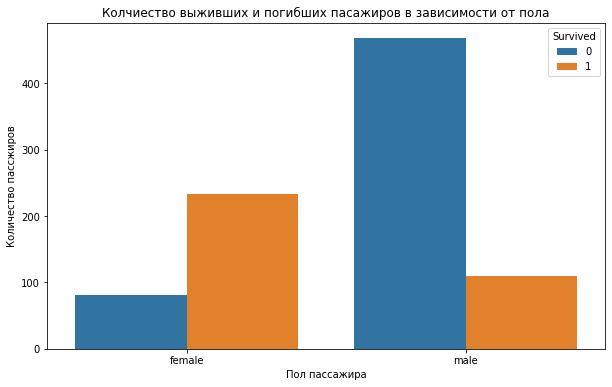

In [15]:
plt.figure(figsize=(10,6))
plt.title('Колчиество выживших и погибших пасажиров в зависимости от пола')

bar = sns.barplot(data=data.pivot_table(index=['Sex', 'Survived'], values='PassengerId', aggfunc='count').reset_index(drop=False),
                 x='Sex',
                 y='PassengerId',
                 hue='Survived')

bar.set_xlabel('Пол пассажира')
bar.set_ylabel('Количество пассжиров')

Количество мужчин в представленном датасете почти в два раза больше, чем женщин, при этом процент выживших среди женщин был значительно выше. Изучим вллияние сочетания класса и пола пострадавшего на выживаемость.

In [16]:
data.pivot_table(index = ['Sex', 'Pclass'], values='Survived', aggfunc=['count', 'mean'])

count      mean
              Survived  Survived
Sex    Pclass                   
female 1            94  0.968085
       2            76  0.921053
       3           144  0.500000
male   1           122  0.368852
       2           108  0.157407
       3           347  0.135447

C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 0.98, 'Колчиество выживших и погибших пасажиров в зависимости от пола пассажира и класса каюты')

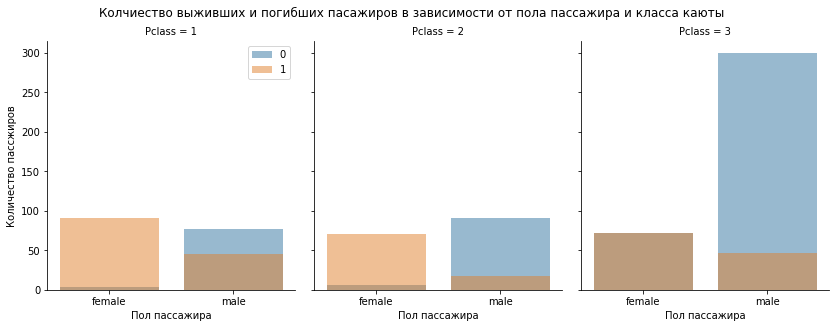

In [17]:
g = sns.FacetGrid(data=data.pivot_table(index = ['Sex', 'Pclass', 'Survived'], values='PassengerId', aggfunc='count').reset_index(drop=False),
                 col='Pclass',
                 hue='Survived')

g.map(sns.barplot,
     'Sex',
     'PassengerId',
     alpha=0.5)

g.axes[0,0].legend()
g.fig.set_size_inches(12,5) 

g.set_xlabels('Пол пассажира')
g.set_ylabels('Количество пассжиров')

g.fig.suptitle('Колчиество выживших и погибших пасажиров в зависимости от пола пассажира и класса каюты')

Обе обнаруженные ранее тенденции наблюдаются и в сводной таблице: женщины выживали чаще мужчин и пассажиры 1 класса выживали чаще, чем пассажиры 3 класса. При этом стоит отметить, что женщины 3 класса всё равно имеют больший процент выживаемости, чем мужчины 1 класса.

Изучим распределение возраста пассажиров на Титанике, для этого остроим гистограмму по соответствующему столбцу

(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

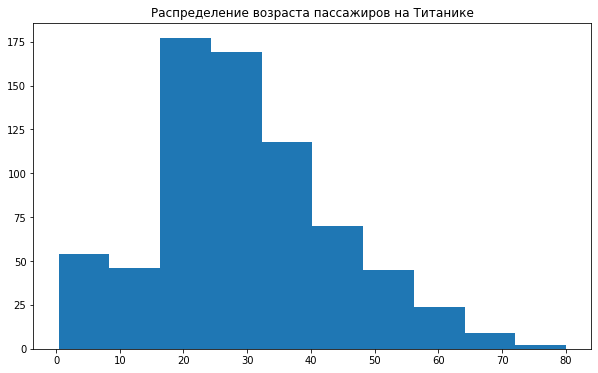

In [18]:
plt.figure(figsize=(10,6))
plt.title('Распределение возраста пассажиров на Титанике')

plt.hist(data['Age'], bins=10)

Распределениенемного отличается от нормального и имеет резкий скачёк в районе 20-30 лет. Построим гистограммы, которые также учту пол пассажира и выжил он или нет.

Text(0.5, 0.98, 'Колчиество выживших и погибших пасажиров в зависимости от пола и возраста пассажира')

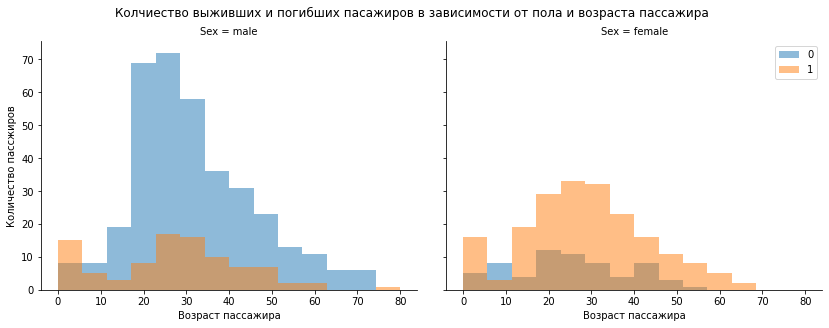

In [19]:
bins = np.linspace(0, max(data['Age']), 15)

g = sns.FacetGrid(data=data,
                 col='Sex',
                 hue='Survived')

g.map(plt.hist,
     'Age',
     bins=bins,
     alpha=0.5)

g.axes[0,1].legend()
g.fig.set_size_inches(12,5) 

g.set_xlabels('Возраст пассажира')
g.set_ylabels('Количество пассжиров')

g.fig.suptitle('Колчиество выживших и погибших пасажиров в зависимости от пола и возраста пассажира')

Создадим сводную таблицу по возрастным категоиям и полу. Возможно, данный параметр будет более информативный, чем возраст сам по себе. 

In [20]:
data['Age_part'] = pd.cut(data[data['Age'].notna()]['Age'], bins=bins)

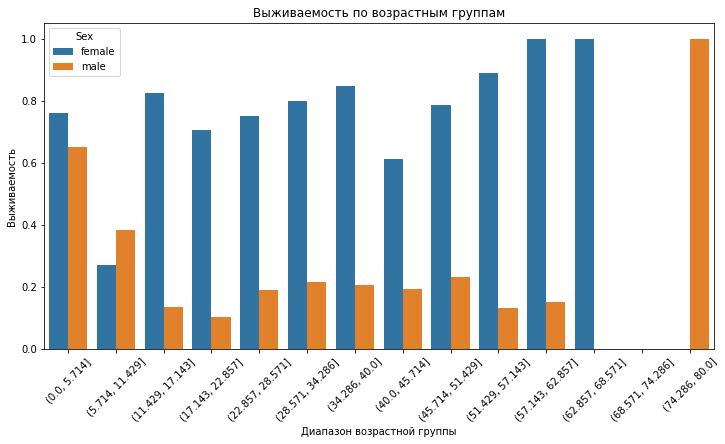

In [21]:
plt.show()
plt.figure(figsize=(12, 6))
plt.title('Выживаемость по возрастным группам')
bar = sns.barplot(data =data.groupby(['Sex','Age_part'])['Survived'].agg('mean').reset_index().sort_values('Age_part'),
            x='Age_part',
            y='Survived',
            hue='Sex')
bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
bar.set_xlabel('Диапазон возрастной группы')
bar.set_ylabel('Выживаемость')
plt.show()

Как видно из полученных данных выживаемость женщин была больше 50% для всех возрастов (кроме 10 летнего возраста, но вероятнее всего, это специфика выборки. У мужчин ситуация была обратной для всех возрастов, кроме детей младше 5 лет (высокая выживаемость в возрасте старше 74 лет у мужчин является скорее выбросом, поскольку таких наблюдений слишком мало). Изучим также как влияет класс на данное распределение.

C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 0.98, 'Колчиество выживших и погибших пасажиров в зависимости от пола, возраста пассажира и класса каюты')

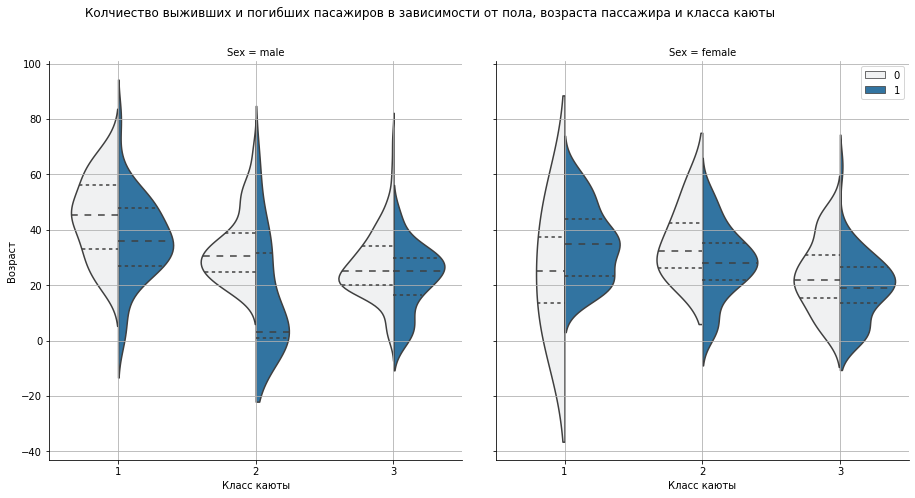

In [22]:
g = sns.FacetGrid(data=data,
                 col='Sex')
g.map(sns.violinplot,
     "Pclass", "Age", hue=data["Survived"], split=True, inner="quart")

g.axes[0,0].grid(True)
g.axes[0,1].grid(True)

g.axes[0,1].legend()
g.fig.set_size_inches(14,8) 

g.set_xlabels('Класс каюты')
g.set_ylabels('Возраст')

g.fig.suptitle('Колчиество выживших и погибших пасажиров в зависимости от пола, возраста пассажира и класса каюты')

Из полученных данных видно, что среднее значение возраста выживших, как правило ниже среднего возраста погибших в каждом классе, кроме женщин путешествующих 1 классом, там эти данные имеют обратное распределение, вероятнее всего это связано с тем, что среди женщин 1 класса было много выживих, и каждая погибшая может оказать сильное влияние на перекос. Кроме того наиболее возрастные пассажиры путешествовали именно 1 классом.

В первоначальных данных два столбца отвечают за наличие родственников на борту: 'SibSp' и 'Parch'. Объединим их и назовём 'Relatives' и изучим их влияние на выживаемость пассажиров.

In [23]:
data['Relatives'] = data['SibSp'] + data['Parch']

In [24]:
data.pivot_table(index='Relatives', values='Survived', aggfunc = ['count', 'mean'])

,count,mean
,Survived,Survived
Relatives,,
0,537,0.303538
1,161,0.552795
2,102,0.578431
3,29,0.724138
4,15,0.200000
5,22,0.136364
6,12,0.333333
7,6,0.000000


Text(0, 0.5, 'Количество пассжиров')

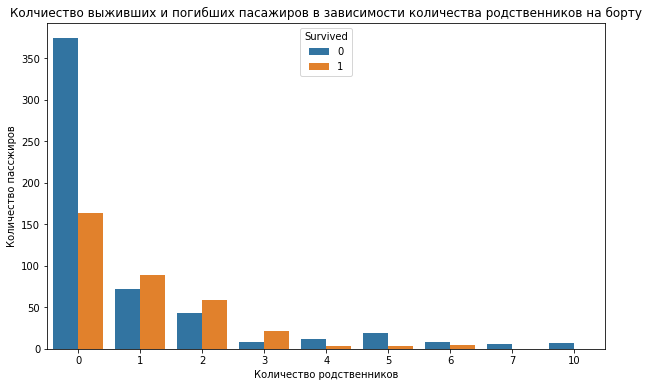

In [25]:
plt.figure(figsize=(10,6))
plt.title('Колчиество выживших и погибших пасажиров в зависимости количества родственников на борту')

bar = sns.barplot(data=data.pivot_table(index=['Relatives', 'Survived'], values='PassengerId', aggfunc = 'count').reset_index(drop=False), 
                   x='Relatives', 
                   y='PassengerId', 
                   hue='Survived')

bar.set_xlabel('Количество родственников')
bar.set_ylabel('Количество пассжиров')

Большинство пассажиров путешествовало без родственников, однако те у кого было от 1 до 3 родственника на борту выживали чаще, те у кого было 7 и более родственников, как правило погибали (возможно это связано с тем, что многодетные семьи путешествовали 3 классом и шансов выжить у них было меньше. Удали созданный столбец, чтобы в предобработке работать с чистым датасетом.

In [26]:
data = data.drop('Relatives', axis=1)

### Выводы

В данном разделе были проанализированны первоначальные данные, Было установлено, что целевой признак очень сильно зависит от пола и класса каюты.

## Предобработка данных

### Создание Pipeline

Создадим pipeline отдельно для категориальных, отдельно для количественных признаков. Для начала создадим списки указанных столбцов, а также список столбцов, в которых указано еоличество родных на титанике.

In [27]:
num_colomns = ['SibSp', 'Parch', 'Fare']

cat_columns = ['Name', 'Sex', 'Pclass', 'Embarked', 'Age']

relatives_colomns =['SibSp', 'Parch']
nan_columns = ['Sex', 'Age', 'Cabin' ]

Создадим класс для выбора объектов из датасета

In [28]:
class DateFrameSelecter (BaseEstimator, TransformerMixin):
    
    def __init__(self, atribute_name):
        self.atribute_name = atribute_name
        
    def fit(self, X, y=None):
        return self
    
    def transform (self, X):
        return X[self.atribute_name]

Для категориального столбца Name нам потребуется также создать класс, который сможет заберать из него информацию

Отключим предупреждения pandas, поскольку при работе с категориальными признаками, нам нужно будет менять значения внутри DateFrame

In [29]:
pd.set_option('mode.chained_assignment', None)

In [30]:
class CatHandler (BaseEstimator, TransformerMixin):
    
    def __init__ (self, cat_columns, colomn_name):
        self.cat_columns = cat_columns
        try:
            self.name_ix = self.cat_columns.index(colomn_name)
            self.colomn_name = colomn_name            
        except:
            self.name_ix = -1
        
    def fit (self, X, y=None):
        return self
    
    def transform (self, X):
        if self.name_ix!=-1:
            X['Tit'] = X[self.colomn_name].str.extract(' ([A-Za-z]+)\.', expand=False)
            titel_map = {'Mr':'Mr','Miss':'Miss', 'Mrs':'Mrs', 'Master':'Master'}
            X['Tit'] = X['Tit'].map(titel_map)
            X['Tit'] = X['Tit'].fillna('other')
            X = X.drop(self.colomn_name, axis=1)
            
        return X

Создадим клас, для объединения данных по семье на борту титаника

In [31]:
class NumHendler (BaseEstimator, TransformerMixin):
    
    def __init__(self, relatives_colomns):
        self.relatives_colomns = relatives_colomns
  
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Relatives'] = 0
        for col in self.relatives_colomns:
            X['Relatives'] += X[col]
        X = X.drop(self.relatives_colomns, axis=1)
                
        return X

Поскольку мы решили преобразовать возраст в возрастные диапазоны (т.е. сделать его из количественного признака - категориальный), то создадим для данного трансформера соответствующий класс.

In [32]:
class AgeToCatAge (BaseEstimator, TransformerMixin):
    
    def __init__ (self, age_colomn, bins=15):
        self.age_colomn = age_colomn
        self.bins = bins
        
    def fit(self, X, y=None):
        return self
    
    def transform (self, X):
        age_bins = np.linspace(0, max(X[self.age_colomn]), self.bins)
        X['Age_part'] = pd.cut(X[self.age_colomn], bins=age_bins)
        X = X.drop(self.age_colomn, axis=1)
        return X        

Сделаем частотное кодирование по столбцам с пропусками. Учитывая, что пол также сильно влияет на выживаемость учтём и данный фактор.

In [33]:
# Получим значения выживаемости для мужчин и женщин с учётом того пропущены у них данные в столбцах или нет. 
# И сделаем соответствующее заполнение
NAN_CABIN_MALE = data[(data['Cabin'].isna()) & (data['Sex']=='male')]['Survived'].mean()
NAN_CABIN_FEMALE = data[(data['Cabin'].isna()) & (data['Sex']=='female')]['Survived'].mean()
TR_CABIN_MALE = data[(data['Cabin'].notna()) & (data['Sex']=='male')]['Survived'].mean()
TR_CABIN_MALE = data[(data['Cabin'].notna()) & (data['Sex']=='female')]['Survived'].mean()

NAN_AGE_MALE = data[(data['Age'].isna()) & (data['Sex']=='male')]['Survived'].mean()
NAN_AGE_FEMALE = data[(data['Age'].isna()) & (data['Sex']=='female')]['Survived'].mean()
TR_AGE_MALE = data[(data['Age'].notna()) & (data['Sex']=='male')]['Survived'].mean()
TR_AGE_MALE =data[(data['Age'].notna()) & (data['Sex']=='female')]['Survived'].mean()

class GetAgeCabNan (BaseEstimator, TransformerMixin):
    
    def __init__ (self, sex_column, age_colomn, colomn_cabin):
        self.age_colomn = age_colomn
        self.colomn_cabin = colomn_cabin
        self.sex_colomn = sex_column
        
    def fit(self, X, y=None):
        self.y = y
        return self
    
    def transform (self, X):
       # X['Nan_Age'] = np.where(X[self.age_colomn].isna(), 1, 0)
       # X['Nan_Cabin'] = np.where(X[self.colomn_cabin].isna(), 1, 0)
       # X = X.drop([self.colomn_cabin, self.age_colomn], axis=1)
        X['Nan_Cabin'] = float(0.)
        X['Nan_Age'] = float(0.)
        
        X['Nan_Cabin'] = np.where(((X[self.colomn_cabin].isna()) & (X[self.sex_colomn]=='male')), NAN_CABIN_MALE, X['Nan_Cabin'])
        X['Nan_Cabin'] = np.where(((X[self.colomn_cabin].isna()) & (X[self.sex_colomn]=='female')), NAN_CABIN_FEMALE, X['Nan_Cabin'])
        X['Nan_Cabin'] = np.where(((X[self.colomn_cabin].notna()) & (X[self.sex_colomn]=='male')), TR_CABIN_MALE, X['Nan_Cabin'])
        X['Nan_Cabin'] = np.where(((X[self.colomn_cabin].notna()) & (X[self.sex_colomn]=='female')), TR_CABIN_MALE, X['Nan_Cabin'])

        X['Nan_Age'] = np.where(((X[self.age_colomn].isna()) & (X[self.sex_colomn]=='male')), NAN_AGE_MALE, X['Nan_Age'])
        X['Nan_Age'] = np.where(((X[self.age_colomn].isna()) & (X[self.sex_colomn]=='female')), NAN_AGE_FEMALE, X['Nan_Age'])
        X['Nan_Age'] = np.where(((X[self.age_colomn].notna()) & (X[self.sex_colomn]=='male')), TR_AGE_MALE, X['Nan_Age'])
        X['Nan_Age'] = np.where(((X[self.age_colomn].notna()) & (X[self.sex_colomn]=='female')), TR_AGE_MALE, X['Nan_Age'])
            
        X = X.drop([self.colomn_cabin, self.age_colomn, self.sex_colomn], axis=1)
        return X    

Создадим количественный pipeline. Заполним пропущенные значения значением -1 (для моделей без встроенной обработки пропущенных значений)

In [34]:
num_pipeline_OHE = Pipeline([
    ('selector1', DateFrameSelecter(num_colomns)),
    ('selector2', NumHendler(relatives_colomns)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

Создадим количественный pipeline, без заполнения пропусков

In [35]:
num_pipeline_without_OHE = Pipeline([
    ('selector1', DateFrameSelecter(num_colomns)),
    ('selector2', NumHendler(relatives_colomns)),
    ('scaler', StandardScaler())
])

Создадим pipeline для количественных столбцов c OHE кодированием

In [36]:
cat_pipeline_OHE = Pipeline([
                 ('selecter', DateFrameSelecter(cat_columns)),       
                 ('selecter_2', CatHandler(cat_columns,'Name')),
                 ('selecter_3', AgeToCatAge('Age', 15)),
                 ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

Создадим pipeline для количественных столбцов без OHE кодированием

In [37]:
cat_pipeline_without_OHE = Pipeline([
                 ('selecter', DateFrameSelecter(cat_columns)),       
                 ('selecter_2', CatHandler(cat_columns,'Name')),
                 ('converter', AgeToCatAge('Age', 15))
])

Создадим пайплайн, для обработки пропусков в столбцах Age и Cabin

In [38]:
nan_pipeline = Pipeline([
                 ('selecter', DateFrameSelecter(nan_columns)),       
                 ('converter', GetAgeCabNan('Sex', 'Age','Cabin'))
])

Создадим полный пайплайн с OHE И без OHE соответственно

In [39]:
ful_pipeline_OHE = FeatureUnion([
                            ('num_pipeline', num_pipeline_OHE),
                            ('cat_pipeline_OHE', cat_pipeline_OHE),
                            ('nan_pipeline', nan_pipeline)
])

In [40]:
ful_pipeline_without_OHE = FeatureUnion([
                            ('num_pipeline', num_pipeline_without_OHE),
                            ('cat_pipeline_without_OHE', cat_pipeline_without_OHE),
                            ('nan_pipeline', nan_pipeline)
])

### Получение признаков и целей для обучения

Разделим датасет на обучающую и тестовую выборки, а затем выделим целевой признак и признаки для обучения.

In [41]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=123, stratify=data['Survived'])

In [42]:
target_train = data_train['Survived']
features_train = data_train.drop('Survived', axis=1)

In [43]:
target_test = data_test['Survived']
features_test = data_test.drop('Survived', axis=1)

Обучим и преобразуем данные с OHE для тренировочной и тестовой выборки

In [44]:
features_OHE_train = ful_pipeline_OHE.fit_transform(features_train, target_train)
features_OHE_test = ful_pipeline_OHE.transform(features_test)

Обучим и преобразуем данные без OHE для тренировочной и тестовой выборки

In [45]:
features_without_OHE_train = ful_pipeline_without_OHE.fit_transform(features_train)
features_without_OHE_test = ful_pipeline_without_OHE.transform(features_test)

Преобразуем данные в датафрейм, чтобы было удобней работать с CatBoost

In [46]:
all_colomns = [ 'Fare', 'Relatives', 'Sex', 'Pclass', 'Embarked', 'Tit',  'Age_part', 'Nan_Age', 'Nan_Cabin']
features_without_OHE_train = pd.DataFrame(data=features_without_OHE_train, columns=all_colomns)
features_without_OHE_test = pd.DataFrame(data=features_without_OHE_test, columns=all_colomns)

Приведём типы категориальных столбцов в нормальное состояние (иначе CatBoost не сможет с ними корректно работать)

In [47]:
features_without_OHE_train[['Sex', 'Pclass', 'Embarked', 'Tit', 'Age_part']] = features_without_OHE_train[['Sex', 'Pclass', 'Embarked', 'Tit', 'Age_part']].astype(str)
features_without_OHE_test[['Sex', 'Pclass', 'Embarked', 'Tit', 'Age_part']] = features_without_OHE_test[['Sex', 'Pclass', 'Embarked', 'Tit', 'Age_part']].astype(str)

Также создадим полную выборку признаков и целей по всему датасету, для финального обучения моделей

In [48]:
target = data['Survived']
features = data.drop('Survived', axis=1)

In [49]:
features_OHE = ful_pipeline_OHE.fit_transform(features)
features_without_OHE = ful_pipeline_without_OHE.fit_transform(features)
features_without_OHE = pd.DataFrame(data=features_without_OHE, columns=all_colomns)
features_without_OHE[['Sex', 'Pclass', 'Embarked', 'Tit', 'Age_part']] = features_without_OHE[['Sex', 'Pclass', 'Embarked', 'Tit', 'Age_part']].astype(str)

### Выводы

В данном разделе были созданы pipline для получения признаков как с OHE так и без него

## Обучение моделей

В данном разделе обучим несколько моделей, проведём подбор гиперпараметров и выберём лучшую из них

### Базовая dummy модель

Создадим и обучим dummy модель, чтобы понимать эффективны ли наши модели машинного обучения

In [50]:
dummy_model = DummyClassifier()
dummy_model.fit(features_OHE_train, target_train)

predictions = dummy_model.predict(features_OHE_test)
print('Метрика accuracy для dummy модели равна', accuracy_score(target_test, predictions))

Метрика accuracy для dummy модели равна 0.6145251396648045


### Логистическая регресия

In [51]:
lin_model = LogisticRegression(class_weight='balanced')
lin_model.fit(features_OHE_train, target_train)

predictions = lin_model.predict(features_OHE_test)
print('Метрика accuracy для логистической регресии равна', accuracy_score(target_test, predictions))

Метрика accuracy для логистической регресии равна 0.7988826815642458


Попробуем улучшить показатель логистической регрессии, для этого подберём коэффициент регляризации C

In [52]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
c_values = np.logspace(-1, 3, 50)

logit_searcher = LogisticRegressionCV(Cs=c_values, 
                                      cv=skf, 
                                      verbose=5, 
                                      n_jobs=-1, 
                                      class_weight='balanced', 
                                      scoring='accuracy')

logit_searcher.fit(features_OHE_train, target_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.8s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished


LogisticRegressionCV(Cs=array([1.00000000e-01, 1.20679264e-01, 1.45634848e-01, 1.75751062e-01,
       2.12095089e-01, 2.55954792e-01, 3.08884360e-01, 3.72759372e-01,
       4.49843267e-01, 5.42867544e-01, 6.55128557e-01, 7.90604321e-01,
       9.54095476e-01, 1.15139540e+00, 1.38949549e+00, 1.67683294e+00,
       2.02358965e+00, 2.44205309e+00, 2.94705170e+00, 3.55648031e+00,
       4.29193426e+00, 5.17...
       4.09491506e+01, 4.94171336e+01, 5.96362332e+01, 7.19685673e+01,
       8.68511374e+01, 1.04811313e+02, 1.26485522e+02, 1.52641797e+02,
       1.84206997e+02, 2.22299648e+02, 2.68269580e+02, 3.23745754e+02,
       3.90693994e+02, 4.71486636e+02, 5.68986603e+02, 6.86648845e+02,
       8.28642773e+02, 1.00000000e+03]),
                     class_weight='balanced',
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1, scoring='accuracy', verbose=5)

In [53]:
print('Метрика accuracy на тренировочной выборке при кросс валидации', logit_searcher.scores_[1].max())

Метрика accuracy на тренировочной выборке при кросс валидации 0.8450704225352113


In [54]:
print('Оптимальное значение гиперпараметра C:', logit_searcher.C_)

Оптимальное значение гиперпараметра C: [0.95409548]


In [55]:
predictions = logit_searcher.predict(features_OHE_test)
print('Метрика accuracy для линейной модели на тестовой выборке после подбора uиперпараметра C равен', accuracy_score(target_test, predictions))

Метрика accuracy для линейной модели на тестовой выборке после подбора uиперпараметра C равен 0.7988826815642458


### Дерево решений

In [56]:
tree_model = DecisionTreeClassifier(class_weight='balanced',
                                    random_state=123)
tree_model.fit(features_OHE_train, target_train)

predictions = tree_model.predict(features_OHE_test)
print('Метрика accuracy для модели решающего дерева', accuracy_score(target_test, predictions))

Метрика accuracy для модели решающего дерева 0.7821229050279329


Попробуем подобрать гиперпараметры при помощи GridSearchCV

In [57]:
tree = DecisionTreeClassifier(class_weight='balanced',
                                    random_state=123)

tree_param = {'max_depth': range(1,20),
              'max_features': range(2,features_OHE_train.shape[1], 10),
              'min_samples_leaf': range(1,10)
             }

tree_grid = GridSearchCV(tree, 
                         tree_param,
                         cv=5, 
                         n_jobs=-1,
                         scoring = 'accuracy',
                         verbose=True)

In [58]:
tree_grid.fit(features_OHE_train, target_train)

Fitting 5 folds for each of 684 candidates, totalling 3420 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 20),
                         'max_features': range(2, 33, 10),
                         'min_samples_leaf': range(1, 10)},
             scoring='accuracy', verbose=True)

Лучшее сочетание параметров для модели решающего дерева:

In [59]:
tree_grid.best_params_

{'max_depth': 4, 'max_features': 22, 'min_samples_leaf': 7}

In [60]:
print('Метрика accuracy для лучшего сочетания параметров модели решающего дерева', tree_grid.best_score_)

Метрика accuracy для лучшего сочетания параметров модели решающего дерева 0.8201516793066089


Посчитаем значение метрики на тестовой выборке

In [61]:
predictions = tree_grid.predict(features_OHE_test)
print('Метрика accuracy для модели решающего дерева на тестовой выборке с оптимальными гиперпараметрами', accuracy_score(target_test, predictions))

Метрика accuracy для модели решающего дерева на тестовой выборке с оптимальными гиперпараметрами 0.8324022346368715


### Модель случайного леса

In [62]:
forest_model = RandomForestClassifier(class_weight='balanced',
                                      random_state=123)

forest_model.fit(features_OHE_train, target_train)

predictions = forest_model.predict(features_OHE_test)
print('Метрика accuracy для модели случайного леса', accuracy_score(target_test, predictions))

Метрика accuracy для модели случайного леса 0.8156424581005587


Попробуем подобрать гиперпараметры при помощи GridSearchCV

In [63]:
%%time
forest = RandomForestClassifier(class_weight='balanced',
                                      random_state=123)

forest_params = {'n_estimators': range(50, 500, 50),
                'max_depth': range(1,15),
                'max_features': range(2,features_OHE_train.shape[1], 10),
                'min_samples_leaf': range(1,4)
             }

forest_grid = GridSearchCV(forest, 
                         forest_params,
                         cv=5, 
                         n_jobs=-1,
                         scoring = 'accuracy',
                         verbose=True)

forest_grid.fit(features_OHE_train, target_train)

Fitting 5 folds for each of 1512 candidates, totalling 7560 fits
CPU times: total: 12.9 s
Wall time: 6min 17s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 15),
                         'max_features': range(2, 33, 10),
                         'min_samples_leaf': range(1, 4),
                         'n_estimators': range(50, 500, 50)},
             scoring='accuracy', verbose=True)

Лучшее сочетание параметров для модели случайного леса:

In [64]:
forest_grid.best_params_

{'max_depth': 6,
 'max_features': 12,
 'min_samples_leaf': 1,
 'n_estimators': 150}

In [65]:
print('Метрика accuracy для лучшего сочетания параметров модели случайного леса равна', forest_grid.best_score_)

Метрика accuracy для лучшего сочетания параметров модели случайного леса равна 0.835585541219344


In [66]:
predictions = forest_grid.predict(features_OHE_test)
print('Метрика accuracy для модели случайного леса на тестовой выборке с оптимальными гиперпараметрами', accuracy_score(target_test, predictions))

Метрика accuracy для модели случайного леса на тестовой выборке с оптимальными гиперпараметрами 0.8100558659217877


### Модель k ближайших соседей

In [67]:
knn_model = KNeighborsClassifier()
knn_model.fit(features_OHE_train, target_train)

predictions = knn_model.predict(features_OHE_test)
print('Метрика accuracy для модели k ближайших соседей', accuracy_score(target_test, predictions))

Метрика accuracy для модели k ближайших соседей 0.7932960893854749


Попробуем подобрать гиперпараметры при помощи GridSearchCV

In [68]:
%time
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': range(1,100)}

knn_grid = GridSearchCV(knn,
                       knn_params,
                       cv=5,
                       n_jobs=-1,
                       scoring = 'accuracy',
                       verbose=True)

knn_grid.fit(features_OHE_train, target_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 100)}, scoring='accuracy',
             verbose=True)

Лучшее сочетание параметров для модели k Ближайших соседей:

In [69]:
knn_grid.best_params_

{'n_neighbors': 21}

In [70]:
print('Метрика accuracy для лучшего сочетания параметров модели knn равна', knn_grid.best_score_)

Метрика accuracy для лучшего сочетания параметров модели knn равна 0.8299418890968188


In [71]:
predictions = knn_grid.predict(features_OHE_test)
print('Метрика accuracy для модели knn на тестовой выборке с оптимальными гиперпараметрами', accuracy_score(target_test, predictions))

Метрика accuracy для модели knn на тестовой выборке с оптимальными гиперпараметрами 0.8156424581005587


### CatBoost с OHE

In [72]:
cat_model = CatBoostClassifier(random_state=123, verbose=100)
cat_model.fit(features_OHE_train, target_train)

predictions = cat_model.predict(features_OHE_test)
print('Метрика accuracy для модели CatBoost с OHE ', accuracy_score(target_test, predictions))

Learning rate set to 0.008911
0:	learn: 0.6865875	total: 159ms	remaining: 2m 39s
100:	learn: 0.4345451	total: 269ms	remaining: 2.4s
200:	learn: 0.3781642	total: 380ms	remaining: 1.51s
300:	learn: 0.3529250	total: 492ms	remaining: 1.14s
400:	learn: 0.3361215	total: 607ms	remaining: 907ms
500:	learn: 0.3225468	total: 721ms	remaining: 718ms
600:	learn: 0.3112884	total: 835ms	remaining: 554ms
700:	learn: 0.2998561	total: 949ms	remaining: 405ms
800:	learn: 0.2872820	total: 1.06s	remaining: 264ms
900:	learn: 0.2756571	total: 1.18s	remaining: 130ms
999:	learn: 0.2655892	total: 1.29s	remaining: 0us
Метрика accuracy для модели CatBoost с OHE  0.8044692737430168


Попробуем улучшить показатели модели при помощи GridSearchCV

In [73]:
%%time
cat = CatBoostClassifier(random_state=123)
cat_param = {'n_estimators': range(50, 1000, 50),
                'max_depth': range(1,16)
             }
cat_grid = GridSearchCV(cat,
                       cat_param,
                       cv=5,
                       n_jobs=-1,
                       scoring = 'accuracy',
                       verbose=True)

cat_grid.fit(features_OHE_train, target_train)

Fitting 5 folds for each of 285 candidates, totalling 1425 fits
Learning rate set to 0.010343
0:	learn: 0.6863684	total: 1.02ms	remaining: 864ms
1:	learn: 0.6801160	total: 2.01ms	remaining: 852ms
2:	learn: 0.6737220	total: 2.97ms	remaining: 838ms
3:	learn: 0.6678108	total: 3.9ms	remaining: 826ms
4:	learn: 0.6619970	total: 4.88ms	remaining: 825ms
5:	learn: 0.6569105	total: 5.9ms	remaining: 830ms
6:	learn: 0.6510600	total: 6.83ms	remaining: 822ms
7:	learn: 0.6457167	total: 7.63ms	remaining: 803ms
8:	learn: 0.6403735	total: 8.61ms	remaining: 805ms
9:	learn: 0.6361912	total: 9.43ms	remaining: 792ms
10:	learn: 0.6313148	total: 10.4ms	remaining: 791ms
11:	learn: 0.6260530	total: 11.3ms	remaining: 791ms
12:	learn: 0.6208630	total: 12.3ms	remaining: 792ms
13:	learn: 0.6159789	total: 13.3ms	remaining: 792ms
14:	learn: 0.6112500	total: 14.2ms	remaining: 791ms
15:	learn: 0.6064046	total: 15.2ms	remaining: 791ms
16:	learn: 0.6025073	total: 16.1ms	remaining: 787ms
17:	learn: 0.5998139	total: 16.6ms

211:	learn: 0.3776291	total: 196ms	remaining: 590ms
212:	learn: 0.3773936	total: 197ms	remaining: 589ms
213:	learn: 0.3769368	total: 198ms	remaining: 588ms
214:	learn: 0.3766945	total: 199ms	remaining: 587ms
215:	learn: 0.3764906	total: 200ms	remaining: 586ms
216:	learn: 0.3761204	total: 201ms	remaining: 585ms
217:	learn: 0.3758902	total: 201ms	remaining: 584ms
218:	learn: 0.3758595	total: 202ms	remaining: 582ms
219:	learn: 0.3755226	total: 203ms	remaining: 581ms
220:	learn: 0.3752148	total: 204ms	remaining: 580ms
221:	learn: 0.3749164	total: 205ms	remaining: 579ms
222:	learn: 0.3748190	total: 205ms	remaining: 578ms
223:	learn: 0.3745547	total: 206ms	remaining: 577ms
224:	learn: 0.3744031	total: 207ms	remaining: 576ms
225:	learn: 0.3741546	total: 208ms	remaining: 575ms
226:	learn: 0.3737347	total: 209ms	remaining: 574ms
227:	learn: 0.3735088	total: 210ms	remaining: 574ms
228:	learn: 0.3734535	total: 211ms	remaining: 572ms
229:	learn: 0.3731595	total: 212ms	remaining: 571ms
230:	learn: 

418:	learn: 0.3402707	total: 384ms	remaining: 394ms
419:	learn: 0.3401223	total: 384ms	remaining: 394ms
420:	learn: 0.3399875	total: 385ms	remaining: 393ms
421:	learn: 0.3398428	total: 386ms	remaining: 392ms
422:	learn: 0.3396716	total: 387ms	remaining: 391ms
423:	learn: 0.3396171	total: 388ms	remaining: 390ms
424:	learn: 0.3395521	total: 389ms	remaining: 389ms
425:	learn: 0.3394226	total: 390ms	remaining: 388ms
426:	learn: 0.3391893	total: 391ms	remaining: 387ms
427:	learn: 0.3389855	total: 391ms	remaining: 386ms
428:	learn: 0.3389054	total: 392ms	remaining: 385ms
429:	learn: 0.3387202	total: 393ms	remaining: 384ms
430:	learn: 0.3385234	total: 394ms	remaining: 383ms
431:	learn: 0.3384143	total: 395ms	remaining: 382ms
432:	learn: 0.3382050	total: 396ms	remaining: 381ms
433:	learn: 0.3381225	total: 397ms	remaining: 380ms
434:	learn: 0.3380049	total: 398ms	remaining: 379ms
435:	learn: 0.3378752	total: 399ms	remaining: 378ms
436:	learn: 0.3377096	total: 399ms	remaining: 377ms
437:	learn: 

623:	learn: 0.3156590	total: 570ms	remaining: 206ms
624:	learn: 0.3155472	total: 571ms	remaining: 206ms
625:	learn: 0.3154596	total: 572ms	remaining: 205ms
626:	learn: 0.3154053	total: 573ms	remaining: 204ms
627:	learn: 0.3152762	total: 574ms	remaining: 203ms
628:	learn: 0.3150839	total: 575ms	remaining: 202ms
629:	learn: 0.3149799	total: 576ms	remaining: 201ms
630:	learn: 0.3148921	total: 577ms	remaining: 200ms
631:	learn: 0.3147387	total: 578ms	remaining: 199ms
632:	learn: 0.3145968	total: 579ms	remaining: 198ms
633:	learn: 0.3145296	total: 580ms	remaining: 197ms
634:	learn: 0.3143369	total: 581ms	remaining: 197ms
635:	learn: 0.3142842	total: 582ms	remaining: 196ms
636:	learn: 0.3142416	total: 582ms	remaining: 195ms
637:	learn: 0.3141615	total: 583ms	remaining: 194ms
638:	learn: 0.3141013	total: 584ms	remaining: 193ms
639:	learn: 0.3140433	total: 585ms	remaining: 192ms
640:	learn: 0.3139704	total: 586ms	remaining: 191ms
641:	learn: 0.3138461	total: 587ms	remaining: 190ms
642:	learn: 

839:	learn: 0.2916979	total: 760ms	remaining: 9.05ms
840:	learn: 0.2916113	total: 761ms	remaining: 8.15ms
841:	learn: 0.2914426	total: 762ms	remaining: 7.24ms
842:	learn: 0.2913324	total: 763ms	remaining: 6.34ms
843:	learn: 0.2912683	total: 764ms	remaining: 5.43ms
844:	learn: 0.2911573	total: 765ms	remaining: 4.53ms
845:	learn: 0.2910921	total: 766ms	remaining: 3.62ms
846:	learn: 0.2908890	total: 766ms	remaining: 2.71ms
847:	learn: 0.2907902	total: 767ms	remaining: 1.81ms
848:	learn: 0.2907493	total: 768ms	remaining: 904us
849:	learn: 0.2907299	total: 769ms	remaining: 0us
CPU times: total: 10.1 s
Wall time: 34min 39s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000234AC884460>,
             n_jobs=-1,
             param_grid={'max_depth': range(1, 16),
                         'n_estimators': range(50, 1000, 50)},
             scoring='accuracy', verbose=True)

Оптимальное сочетание параметров для модели CatBoost с OHE

In [74]:
cat_grid.best_params_

{'max_depth': 5, 'n_estimators': 850}

In [75]:
print('Метрика accuracy для лучшего сочетания параметров модели CatBoost с OHE равна', cat_grid.best_score_)

Метрика accuracy для лучшего сочетания параметров модели CatBoost с OHE равна 0.8440559440559442


In [76]:
predictions = cat_grid.predict(features_OHE_test)
print('Метрика accuracy для модели CatBoost с OHE на тестовой выборке с оптимальными гиперпараметрами', accuracy_score(target_test, predictions))

Метрика accuracy для модели CatBoost с OHE на тестовой выборке с оптимальными гиперпараметрами 0.8100558659217877


#### Встроенная кроссвалидация

У CatBoost есть ввстроенная кросс валидация, посмотрим, какие резкльтаты даст она

In [77]:
params = {
    'loss_function': 'Logloss',
    'iterations': 3000,
    'custom_loss': 'Accuracy'
}

cv_data = cv(
    params=params,
    pool=Pool(data=features_OHE_train, label=target_train),
    fold_count=5,
    shuffle=False, 
    partition_random_seed=0,
    stratified=True, 
    verbose=False
)


Training on fold [0/5]

bestTest = 0.3243361607
bestIteration = 180

Training on fold [1/5]

bestTest = 0.4310689501
bestIteration = 320

Training on fold [2/5]

bestTest = 0.421050042
bestIteration = 124

Training on fold [3/5]

bestTest = 0.4115143209
bestIteration = 350

Training on fold [4/5]

bestTest = 0.4530510109
bestIteration = 93



In [78]:
best_value = np.max(cv_data['test-Accuracy-mean'])
best_iter = np.argmax(cv_data['test-Accuracy-mean'])
print("Лучшее значение Accuracy: {:.4f}+/-{:.3f} на шаге {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

Лучшее значение Accuracy: 0.8441+/-0.048 на шаге 342


In [79]:
cat_model_OHE_CV = CatBoostClassifier(iterations=318,
                               custom_loss = 'Accuracy')
cat_model_OHE_CV.fit(features_OHE_train, target_train,
             verbose=False
             )

predictions = cat_model_OHE_CV.predict(features_OHE_test)
print('Метрика accuracy для модели CatBoost с OHE на тестовой выборке по встроенной кросс валидации', accuracy_score(target_test, predictions))

Метрика accuracy для модели CatBoost с OHE на тестовой выборке по встроенной кросс валидации 0.8044692737430168


### CatBoost без OHE

In [80]:
cat_colomns = ['Sex', 'Pclass', 'Embarked', 'Tit', 'Age_part']
cat_model_without_OHE = CatBoostClassifier(random_state=123, 
                                           verbose=100, 
                                           cat_features=cat_colomns
                                          )
cat_model_without_OHE.fit(features_without_OHE_train, target_train)

predictions = cat_model_without_OHE.predict(features_without_OHE_test)
print('Метрика accuracy для модели CatBoost без OHE ', accuracy_score(target_test, predictions))

Learning rate set to 0.008911
0:	learn: 0.6891456	total: 11.6ms	remaining: 11.6s
100:	learn: 0.4437468	total: 1.13s	remaining: 10.1s
200:	learn: 0.3880910	total: 2.18s	remaining: 8.66s
300:	learn: 0.3614615	total: 3.19s	remaining: 7.4s
400:	learn: 0.3440940	total: 4.17s	remaining: 6.22s
500:	learn: 0.3320783	total: 5.19s	remaining: 5.17s
600:	learn: 0.3188823	total: 6.17s	remaining: 4.1s
700:	learn: 0.3061481	total: 7.28s	remaining: 3.1s
800:	learn: 0.2949479	total: 8.31s	remaining: 2.06s
900:	learn: 0.2854988	total: 9.3s	remaining: 1.02s
999:	learn: 0.2761174	total: 10.3s	remaining: 0us
Метрика accuracy для модели CatBoost без OHE  0.8212290502793296


Попробуем улучшить показатели модели при помощи GridSearchCV

In [81]:
%%time
cat_w = CatBoostClassifier(random_state=123, cat_features=cat_colomns)
cat_param_w = {'n_estimators': range(50, 1000, 50),
                'max_depth': range(1,16)
             }
cat_grid_w = GridSearchCV(cat_w,
                       cat_param_w,
                       cv=5,
                       n_jobs=-1,
                       scoring = 'accuracy',
                       verbose=True)

cat_grid_w.fit(features_without_OHE_train, target_train)

Fitting 5 folds for each of 285 candidates, totalling 1425 fits
Learning rate set to 0.009341
0:	learn: 0.6889536	total: 4.66ms	remaining: 4.42s
1:	learn: 0.6838303	total: 11.6ms	remaining: 5.51s
2:	learn: 0.6782423	total: 18.6ms	remaining: 5.87s
3:	learn: 0.6727305	total: 25.3ms	remaining: 5.98s
4:	learn: 0.6693738	total: 29ms	remaining: 5.48s
5:	learn: 0.6647267	total: 36ms	remaining: 5.67s
6:	learn: 0.6605323	total: 42.7ms	remaining: 5.75s
7:	learn: 0.6555945	total: 49.4ms	remaining: 5.82s
8:	learn: 0.6510142	total: 57.1ms	remaining: 5.97s
9:	learn: 0.6468142	total: 63.6ms	remaining: 5.98s
10:	learn: 0.6416397	total: 70.3ms	remaining: 6s
11:	learn: 0.6377002	total: 76.9ms	remaining: 6.01s
12:	learn: 0.6339226	total: 83.7ms	remaining: 6.03s
13:	learn: 0.6301785	total: 88.8ms	remaining: 5.94s
14:	learn: 0.6253730	total: 95.9ms	remaining: 5.98s
15:	learn: 0.6220745	total: 104ms	remaining: 6.05s
16:	learn: 0.6183803	total: 110ms	remaining: 6.06s
17:	learn: 0.6144189	total: 118ms	remaini

165:	learn: 0.4232944	total: 1.22s	remaining: 5.76s
166:	learn: 0.4230048	total: 1.23s	remaining: 5.76s
167:	learn: 0.4227489	total: 1.24s	remaining: 5.79s
168:	learn: 0.4223193	total: 1.25s	remaining: 5.79s
169:	learn: 0.4219830	total: 1.26s	remaining: 5.78s
170:	learn: 0.4214679	total: 1.27s	remaining: 5.77s
171:	learn: 0.4211632	total: 1.27s	remaining: 5.76s
172:	learn: 0.4207897	total: 1.28s	remaining: 5.74s
173:	learn: 0.4203213	total: 1.28s	remaining: 5.73s
174:	learn: 0.4198418	total: 1.29s	remaining: 5.72s
175:	learn: 0.4194992	total: 1.3s	remaining: 5.71s
176:	learn: 0.4191742	total: 1.3s	remaining: 5.7s
177:	learn: 0.4188022	total: 1.31s	remaining: 5.68s
178:	learn: 0.4183304	total: 1.31s	remaining: 5.67s
179:	learn: 0.4179143	total: 1.32s	remaining: 5.65s
180:	learn: 0.4176055	total: 1.33s	remaining: 5.64s
181:	learn: 0.4172914	total: 1.33s	remaining: 5.63s
182:	learn: 0.4168720	total: 1.34s	remaining: 5.62s
183:	learn: 0.4166253	total: 1.35s	remaining: 5.61s
184:	learn: 0.4

353:	learn: 0.3841936	total: 2.48s	remaining: 4.18s
354:	learn: 0.3841418	total: 2.49s	remaining: 4.18s
355:	learn: 0.3840192	total: 2.5s	remaining: 4.17s
356:	learn: 0.3840104	total: 2.51s	remaining: 4.16s
357:	learn: 0.3839815	total: 2.51s	remaining: 4.16s
358:	learn: 0.3839113	total: 2.52s	remaining: 4.15s
359:	learn: 0.3838525	total: 2.52s	remaining: 4.14s
360:	learn: 0.3837206	total: 2.53s	remaining: 4.13s
361:	learn: 0.3836691	total: 2.54s	remaining: 4.12s
362:	learn: 0.3836407	total: 2.54s	remaining: 4.12s
363:	learn: 0.3836084	total: 2.55s	remaining: 4.11s
364:	learn: 0.3834513	total: 2.56s	remaining: 4.1s
365:	learn: 0.3834417	total: 2.57s	remaining: 4.09s
366:	learn: 0.3833118	total: 2.57s	remaining: 4.09s
367:	learn: 0.3832696	total: 2.58s	remaining: 4.08s
368:	learn: 0.3831296	total: 2.58s	remaining: 4.07s
369:	learn: 0.3831124	total: 2.59s	remaining: 4.06s
370:	learn: 0.3829537	total: 2.6s	remaining: 4.06s
371:	learn: 0.3828309	total: 2.61s	remaining: 4.05s
372:	learn: 0.3

515:	learn: 0.3697131	total: 3.52s	remaining: 2.96s
516:	learn: 0.3697033	total: 3.53s	remaining: 2.95s
517:	learn: 0.3696302	total: 3.53s	remaining: 2.95s
518:	learn: 0.3694742	total: 3.55s	remaining: 2.95s
519:	learn: 0.3694508	total: 3.56s	remaining: 2.94s
520:	learn: 0.3693844	total: 3.57s	remaining: 2.94s
521:	learn: 0.3693255	total: 3.6s	remaining: 2.95s
522:	learn: 0.3691582	total: 3.61s	remaining: 2.94s
523:	learn: 0.3690430	total: 3.62s	remaining: 2.94s
524:	learn: 0.3689079	total: 3.62s	remaining: 2.93s
525:	learn: 0.3688557	total: 3.63s	remaining: 2.93s
526:	learn: 0.3686900	total: 3.64s	remaining: 2.92s
527:	learn: 0.3685964	total: 3.64s	remaining: 2.91s
528:	learn: 0.3685623	total: 3.65s	remaining: 2.9s
529:	learn: 0.3685234	total: 3.65s	remaining: 2.9s
530:	learn: 0.3684726	total: 3.66s	remaining: 2.89s
531:	learn: 0.3683999	total: 3.67s	remaining: 2.88s
532:	learn: 0.3683462	total: 3.67s	remaining: 2.88s
533:	learn: 0.3682728	total: 3.68s	remaining: 2.87s
534:	learn: 0.3

701:	learn: 0.3543682	total: 4.75s	remaining: 1.68s
702:	learn: 0.3543521	total: 4.76s	remaining: 1.67s
703:	learn: 0.3542053	total: 4.76s	remaining: 1.66s
704:	learn: 0.3540677	total: 4.77s	remaining: 1.66s
705:	learn: 0.3539298	total: 4.78s	remaining: 1.65s
706:	learn: 0.3538990	total: 4.78s	remaining: 1.64s
707:	learn: 0.3538384	total: 4.79s	remaining: 1.64s
708:	learn: 0.3537400	total: 4.79s	remaining: 1.63s
709:	learn: 0.3537153	total: 4.8s	remaining: 1.62s
710:	learn: 0.3536655	total: 4.81s	remaining: 1.61s
711:	learn: 0.3536501	total: 4.81s	remaining: 1.61s
712:	learn: 0.3535738	total: 4.82s	remaining: 1.6s
713:	learn: 0.3535622	total: 4.83s	remaining: 1.59s
714:	learn: 0.3533826	total: 4.83s	remaining: 1.59s
715:	learn: 0.3533015	total: 4.84s	remaining: 1.58s
716:	learn: 0.3533013	total: 4.84s	remaining: 1.57s
717:	learn: 0.3532375	total: 4.85s	remaining: 1.57s
718:	learn: 0.3531794	total: 4.86s	remaining: 1.56s
719:	learn: 0.3531794	total: 4.86s	remaining: 1.55s
720:	learn: 0.

869:	learn: 0.3444881	total: 5.81s	remaining: 534ms
870:	learn: 0.3444856	total: 5.82s	remaining: 527ms
871:	learn: 0.3443624	total: 5.82s	remaining: 521ms
872:	learn: 0.3442961	total: 5.83s	remaining: 514ms
873:	learn: 0.3442249	total: 5.83s	remaining: 507ms
874:	learn: 0.3442082	total: 5.84s	remaining: 501ms
875:	learn: 0.3441401	total: 5.85s	remaining: 494ms
876:	learn: 0.3441102	total: 5.85s	remaining: 487ms
877:	learn: 0.3440360	total: 5.86s	remaining: 481ms
878:	learn: 0.3439706	total: 5.87s	remaining: 474ms
879:	learn: 0.3439311	total: 5.87s	remaining: 467ms
880:	learn: 0.3438454	total: 5.88s	remaining: 460ms
881:	learn: 0.3437746	total: 5.88s	remaining: 454ms
882:	learn: 0.3437304	total: 5.89s	remaining: 447ms
883:	learn: 0.3436578	total: 5.9s	remaining: 440ms
884:	learn: 0.3436348	total: 5.9s	remaining: 434ms
885:	learn: 0.3436109	total: 5.91s	remaining: 427ms
886:	learn: 0.3435778	total: 5.91s	remaining: 420ms
887:	learn: 0.3435096	total: 5.92s	remaining: 413ms
888:	learn: 0.

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000234ACF26BC0>,
             n_jobs=-1,
             param_grid={'max_depth': range(1, 16),
                         'n_estimators': range(50, 1000, 50)},
             scoring='accuracy', verbose=True)

Оптимальное сочетание параметров для модели CatBoost без OHE

In [82]:
cat_grid_w.best_params_

{'max_depth': 4, 'n_estimators': 950}

In [83]:
print('Метрика accuracy для лучшего сочетания параметров модели CatBoost без OHE равна', cat_grid_w.best_score_)

Метрика accuracy для лучшего сочетания параметров модели CatBoost без OHE равна 0.8370038412291934


In [84]:
predictions = cat_grid_w.predict(features_without_OHE_test)
print('Метрика accuracy для модели CatBoost без OHE на тестовой выборке с оптимальными гиперпараметрами', accuracy_score(target_test, predictions))

Метрика accuracy для модели CatBoost без OHE на тестовой выборке с оптимальными гиперпараметрами 0.8324022346368715


#### Встроенная кроссвалидация

In [85]:
params = {
    'loss_function': 'Logloss',
    'iterations': 3000,
    'custom_loss': 'Accuracy'
}

cv_data = cv(
    params=params,
    pool=Pool(data=features_without_OHE_train, label=target_train, cat_features=cat_colomns),
    fold_count=5,
    shuffle=False, 
    partition_random_seed=0,
    stratified=True, 
    verbose=False
)

Training on fold [0/5]

bestTest = 0.3186655234
bestIteration = 284

Training on fold [1/5]

bestTest = 0.4337654834
bestIteration = 369

Training on fold [2/5]

bestTest = 0.4275544808
bestIteration = 364

Training on fold [3/5]

bestTest = 0.4285205715
bestIteration = 309

Training on fold [4/5]

bestTest = 0.4615652952
bestIteration = 72



In [86]:
best_value = np.max(cv_data['test-Accuracy-mean'])
best_iter = np.argmax(cv_data['test-Accuracy-mean'])
print("Лучшее значение Accuracy: {:.4f}+/-{:.3f} на шаге {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

Лучшее значение Accuracy: 0.8370+/-0.054 на шаге 597


In [87]:
cat_model_without_OHE_CV = CatBoostClassifier(iterations=52,
                                              custom_loss = 'Accuracy',
                                              cat_features=cat_colomns)
cat_model_without_OHE_CV.fit(features_without_OHE_train, target_train,
             verbose=False
             )

predictions = cat_model_without_OHE_CV.predict(features_without_OHE_test)
print('Метрика accuracy для модели CatBoost с OHE на тестовой выборке по встроенной кросс валидации', accuracy_score(target_test, predictions))

Метрика accuracy для модели CatBoost с OHE на тестовой выборке по встроенной кросс валидации 0.8324022346368715


### Сравнение моделей

Сравним все рассмотренные модели. Для этого сведём данные по ним в единую таблицу

In [149]:
df_result = pd.DataFrame({
    'Модель':['Dummy модель',
              'Логистическая регресия', 
              'Решающее дерево', 
              'Случайны лес', 
              'Модель k ближайших соседей', 
              'CatBoost с OHE', 
              'CatBoost с OHE со встроенной CV',
              'CatBoost без OHE', 
              'CatBoost без OHE со встроенной CV'],
    'Accuracy (тест) с параметрами по умолчанию': [0.6145, 0.7989, 0.7821, 0.8156, 0.7933, 0.8044, 0.8044, 0.8212, 0.8212],
    'Оптимальные параметры (кроссвалидация)':['нет',
                                              'С = 0.95409548', 
                                              "'max_depth': 4, 'max_features': 22, 'min_samples_leaf': 7", 
                                              "'max_depth': 6,  'max_features': 12, 'min_samples_leaf': 1, 'n_estimators': 150", 
                                              "'n_neighbors': 21", 
                                              "'max_depth': 5, 'n_estimators': 850", 
                                              "iterations = 342	",
                                              "'max_depth': 4, 'n_estimators': 950",
                                             "iterations = 597"],
    'Accuracy (кроссвалидация) с оптимальными параметрами': [0.6145, 0.8451, 0.8202, 0.8359, 0.8299, 0.8441, 0.8441, 0.8370, 0.8370],
    'Accuracy (Тест) с оптимальными параметрами': [0.6145, 0.7989, 0.8324, 0.8100, 0.8156, 0.8106, 0.8045, 0.8324, 0.8324],
    })

In [150]:
display(df_result.style
 .background_gradient(subset=['Accuracy (тест) с параметрами по умолчанию',
                              'Accuracy (кроссвалидация) с оптимальными параметрами', 
                              'Accuracy (Тест) с оптимальными параметрами'], 
                      cmap='Blues'))

,Модель,Accuracy (тест) с параметрами по умолчанию,Оптимальные параметры (кроссвалидация),Accuracy (кроссвалидация) с оптимальными параметрами,Accuracy (Тест) с оптимальными параметрами
0,Dummy модель,0.614500,нет,0.614500,0.614500
1,Логистическая регресия,0.798900,С = 0.95409548,0.845100,0.798900
2,Решающее дерево,0.782100,"'max_depth': 4, 'max_features': 22, 'min_samples_leaf': 7",0.820200,0.832400
3,Случайны лес,0.815600,"'max_depth': 6, 'max_features': 12, 'min_samples_leaf': 1, 'n_estimators': 150",0.835900,0.810000
4,Модель k ближайших соседей,0.793300,'n_neighbors': 21,0.829900,0.815600
5,CatBoost с OHE,0.804400,"'max_depth': 5, 'n_estimators': 850",0.844100,0.810600
6,CatBoost с OHE со встроенной CV,0.804400,iterations = 342,0.844100,0.804500
7,CatBoost без OHE,0.821200,"'max_depth': 4, 'n_estimators': 950",0.837000,0.832400
8,CatBoost без OHE со встроенной CV,0.821200,iterations = 597,0.837000,0.832400


Все модели дают результат вышем чем dummy предсказатель.  После подбора гиперпараметров все модели показывают хорошее качество как на кроссвалиадции так и на тесте. Также можено отметить, что по моделям CatBoost встроенная кроссвалидация даёт примерно такие же результаты как и посик по сетке, но занимает значительно меньше времени. Обучим все модели с оптимальными гиперпараметрами

In [151]:
lin_model = LogisticRegression(class_weight='balanced', C=0.95409548)
lin_model.fit(features_OHE_train, target_train)

LogisticRegression(C=0.95409548, class_weight='balanced')

In [152]:
tree_model = DecisionTreeClassifier(class_weight='balanced',
                                   random_state=123,
                                   max_depth=4,
                                   max_features=22,
                                   min_samples_leaf=7)
tree_model.fit(features_OHE_train, target_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_features=22,
                       min_samples_leaf=7, random_state=123)

In [153]:
forest_model = RandomForestClassifier(class_weight='balanced',
                                     random_state=123,
                                     max_depth=6,
                                     max_features=12,
                                     min_samples_leaf=1,
                                     n_estimators=150)
forest_model.fit(features_OHE_train, target_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=12,
                       n_estimators=150, random_state=123)

In [154]:
knn_model = KNeighborsClassifier(n_neighbors=21)
knn_model.fit(features_OHE_train, target_train)

KNeighborsClassifier(n_neighbors=21)

In [155]:
cat_model_OHE = CatBoostClassifier(random_state=123, 
                                   verbose=100,
                                  max_depth=5,
                                  n_estimators=850)
cat_model_OHE.fit(features_OHE_train, target_train)

Learning rate set to 0.010343
0:	learn: 0.6863684	total: 1.39ms	remaining: 1.18s
100:	learn: 0.4285998	total: 93.2ms	remaining: 691ms
200:	learn: 0.3805668	total: 181ms	remaining: 585ms
300:	learn: 0.3583353	total: 268ms	remaining: 488ms
400:	learn: 0.3426128	total: 355ms	remaining: 397ms
500:	learn: 0.3291788	total: 442ms	remaining: 308ms
600:	learn: 0.3185051	total: 529ms	remaining: 219ms
700:	learn: 0.3071176	total: 615ms	remaining: 131ms
800:	learn: 0.2959601	total: 701ms	remaining: 42.9ms
849:	learn: 0.2907299	total: 745ms	remaining: 0us


In [156]:
cat_model_OHE_CV = CatBoostClassifier(random_state=123, 
                                   verbose=318,
                                  iterations = 342)
cat_model_OHE_CV.fit(features_OHE_train, target_train)

Learning rate set to 0.023836
0:	learn: 0.6757891	total: 1.38ms	remaining: 471ms
318:	learn: 0.2820808	total: 348ms	remaining: 25.1ms
341:	learn: 0.2752767	total: 372ms	remaining: 0us


In [157]:
cat_model_without_OHE = CatBoostClassifier(random_state=123, 
                                           verbose=100, 
                                           cat_features=cat_colomns,
                                           max_depth=4,
                                           n_estimators=950)
cat_model_without_OHE.fit(features_without_OHE_train, target_train)

Learning rate set to 0.009341
0:	learn: 0.6889536	total: 5.43ms	remaining: 5.15s
100:	learn: 0.4596171	total: 674ms	remaining: 5.67s
200:	learn: 0.4109885	total: 1.35s	remaining: 5.02s
300:	learn: 0.3911101	total: 2.06s	remaining: 4.45s
400:	learn: 0.3802962	total: 2.75s	remaining: 3.76s
500:	learn: 0.3711851	total: 3.36s	remaining: 3.01s
600:	learn: 0.3629054	total: 3.99s	remaining: 2.32s
700:	learn: 0.3544772	total: 4.62s	remaining: 1.64s
800:	learn: 0.3488296	total: 5.24s	remaining: 974ms
900:	learn: 0.3429870	total: 5.89s	remaining: 320ms
949:	learn: 0.3400200	total: 6.23s	remaining: 0us


In [158]:
cat_model_without_OHE_CV = CatBoostClassifier(random_state=123, 
                                           verbose=100, 
                                           cat_features=cat_colomns,
                                           iterations = 597)
cat_model_without_OHE_CV.fit(features_without_OHE_train, target_train)

Learning rate set to 0.014301
0:	learn: 0.6867465	total: 4.56ms	remaining: 2.72s
100:	learn: 0.4051725	total: 1.12s	remaining: 5.5s
200:	learn: 0.3596026	total: 2.21s	remaining: 4.35s
300:	learn: 0.3337044	total: 3.23s	remaining: 3.18s
400:	learn: 0.3142314	total: 4.23s	remaining: 2.07s
500:	learn: 0.2990143	total: 5.23s	remaining: 1s
596:	learn: 0.2847737	total: 6.31s	remaining: 0us


Построим roc кривые для полученных моделей

C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot

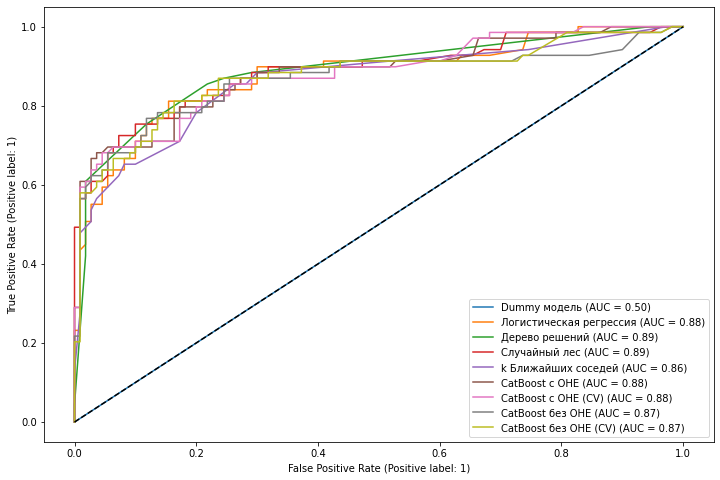

In [159]:
plt.figure(figsize =(12,8))
roc_disp = plot_roc_curve(dummy_model, features_OHE_test, target_test, ax=plt.axes(), name='Dummy модель')
plot_roc_curve(lin_model, features_OHE_test, target_test, ax=roc_disp.ax_, name='Логистическая регрессия')
plot_roc_curve(tree_model, features_OHE_test, target_test, ax=roc_disp.ax_, name='Дерево решений')
plot_roc_curve(forest_model, features_OHE_test, target_test, ax=roc_disp.ax_, name='Случайный лес')
plot_roc_curve(knn_model, features_OHE_test, target_test, ax=roc_disp.ax_, name='k Ближайших соседей')
plot_roc_curve(cat_model_OHE, features_OHE_test, target_test, ax=roc_disp.ax_, name='CatBoost с OHE')
plot_roc_curve(cat_model_OHE_CV, features_OHE_test, target_test, ax=roc_disp.ax_, name='CatBoost с OHE (CV)')
plot_roc_curve(cat_model_without_OHE, features_without_OHE_test, target_test, ax=roc_disp.ax_, name='CatBoost без OHE')
plot_roc_curve(cat_model_without_OHE_CV, features_without_OHE_test, target_test, ax=roc_disp.ax_, name='CatBoost без OHE (CV)')
roc_disp.ax_.plot([0,1],[0,1], 'k--');

Как видно из графика почти все модели имеют одинаковое распределение. Попробуем подобрать пороги принятия решений для всех моделей (кроме k ближайших соседей, там такой возможности нет).

#### Улучшение моделей

Напишим функции для рассчёта предсказаний в зависимости от порога и кроссвалидационной проверки подбора порога

In [160]:
# Функция для возвращаения значения в зависимости от порога
def get_predict (model, threshold, feature):
    
    new_predict =[]
    
    probabilities = model.predict_proba(feature)
    probabilities_one = probabilities[:, 1]

    for predict in probabilities_one:                 

        if predict>threshold:
            new_predict.append(1)
        else:
            new_predict.append(0)
                
    return np.array(new_predict)

In [161]:
def thresholds_cv (model, feature, target):

    target = target.reset_index(drop=True)
    
    kfold = KFold(n_splits=5)

    probabilities_valid = model.predict_proba(feature)
    probabilities_one_valid= probabilities_valid[:, 1]

    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)

    opt_threshold = 0
    opt_accuracy=0

    for threshold in notebook.tqdm(thresholds): 

        accuracy_list =[]

        for train_index, valid_index in kfold.split(target):

            futures_train = feature[train_index]
            futures_valid = feature[valid_index]

            target_train_kfold = target[train_index]
            target_valid = target[valid_index]

            predictions = get_predict(model, threshold, futures_valid)

            accuracy_kfold = accuracy_score(target_valid, np.array(predictions))
            accuracy_list.append(accuracy_kfold)

        if np.mean(accuracy_list)>opt_accuracy:        
            opt_threshold = threshold
            opt_accuracy = np.mean(accuracy_list)

    print(f'Оптимальное порог = {opt_threshold},\t accuracy={opt_accuracy}')    

Подбор порога дя <b>линейной модели</b> на кросс-валидации

In [162]:
thresholds_cv (lin_model, features_OHE_train, target_train)

  0%|          | 0/254 [00:00<?, ?it/s]

Оптимальное порог = 0.6899475198534974,	 accuracy=0.8383925933221708


Проверка на тесте

In [163]:
predictions = get_predict (lin_model, 0.68995, features_OHE_test)
print('Метрика accuracy для линейной модели с оптимальным порогом', accuracy_score(predictions, target_test))

Метрика accuracy для линейной модели с оптимальным порогом 0.8212290502793296


Подбор порога дя <b>дерева решений</b> на кросс-валидации

In [164]:
thresholds_cv (tree_model, features_OHE_train, target_train)

  0%|          | 0/14 [00:00<?, ?it/s]

Оптимальное порог = 0.4530718795531813,	 accuracy=0.8412390426474934


Проверка на тесте

In [165]:
predictions = get_predict (tree_model, 0.45307, features_OHE_test)
print('Метрика accuracy для дерева решения с оптимальным порогом', accuracy_score(predictions, target_test))

Метрика accuracy для дерева решения с оптимальным порогом 0.8100558659217877


Подбор порога дя <b>случайного леса</b> на кросс-валидации

In [166]:
thresholds_cv (forest_model, features_OHE_train, target_train)

  0%|          | 0/240 [00:00<?, ?it/s]

Оптимальное порог = 0.6327676602978759,	 accuracy=0.8833842214123905


Проверка на тесте

In [167]:
predictions = get_predict (forest_model, 0.63276, features_OHE_test)
print('Метрика accuracy для случайного леса с оптимальным порогом', accuracy_score(predictions, target_test))

Метрика accuracy для случайного леса с оптимальным порогом 0.8324022346368715


Подбор порога дя <b>CatBoost с OHE</b> на кросс-валидации

In [168]:
thresholds_cv (cat_model_OHE, features_OHE_train, target_train)

  0%|          | 0/206 [00:00<?, ?it/s]

Оптимальное порог = 0.5073345940214479,	 accuracy=0.9016546833448242


In [169]:
predictions = get_predict (cat_model_OHE, 0.50733, features_OHE_test)
print('Метрика accuracy для CatBoost с OHE с оптимальным порогом', accuracy_score(predictions, target_test))

Метрика accuracy для CatBoost с OHE с оптимальным порогом 0.8044692737430168


Подбор порога дя <b>CatBoost с OHE (CV)</b> на кросс-валидации

In [170]:
thresholds_cv (cat_model_OHE_CV, features_OHE_train, target_train)

  0%|          | 0/182 [00:00<?, ?it/s]

Оптимальное порог = 0.49694226226251154,	 accuracy=0.9115039889687777


In [171]:
predictions = get_predict (cat_model_OHE_CV, 0.49694, features_OHE_test)
print('Метрика accuracy для CatBoost с OHE (CV) с оптимальным порогом', accuracy_score(predictions, target_test))

Метрика accuracy для CatBoost с OHE (CV) с оптимальным порогом 0.8044692737430168


Подбор порога дя <b>CatBoost без OHE</b> на кросс-валидации

In [172]:
thresholds_cv (cat_model_without_OHE, features_without_OHE_train.values, target_train)

  0%|          | 0/240 [00:00<?, ?it/s]

Оптимальное порог = 0.49546612559025094,	 accuracy=0.8608982566729045


In [173]:
predictions = get_predict (cat_model_without_OHE, 0.49547, features_without_OHE_test)
print('Метрика accuracy для CatBoost без OHE с оптимальным порогом', accuracy_score(predictions, target_test))

Метрика accuracy для CatBoost без OHE с оптимальным порогом 0.8324022346368715


Подбор порога дя <b>CatBoost без OHE (CV)</b> на кросс-валидации

In [174]:
thresholds_cv (cat_model_without_OHE_CV, features_without_OHE_train.values, target_train)

  0%|          | 0/227 [00:00<?, ?it/s]

Оптимальное порог = 0.49169224574793224,	 accuracy=0.877760267901113


In [175]:
predictions = get_predict (cat_model_without_OHE_CV, 0.49169, features_without_OHE_test)
print('Метрика accuracy для CatBoost без OHE (CV) с оптимальным порогом', accuracy_score(predictions, target_test))

Метрика accuracy для CatBoost без OHE (CV) с оптимальным порогом 0.8212290502793296


Добавим полученные данные в сводную таблицу

In [176]:
df_result['Оптимальный порог'] = [np.nan, 0.68995, 0.45307, 0.63276, np.nan, 0.50733, 0.49694, 0.49547, 0.49169]
df_result['Результат на трейне (оптимальный порог)'] = [np.nan, 0.8384, 0.8412, 0.8834, np.nan, 0.9017, 0.9115, 0.8609, 0.8778]
df_result['Результат на тесте (оптимальный порог)'] = [np.nan, 0.8212, 0.8101, 0.8324, np.nan, 0.8045, 0.8045, 0.8324, 0.8212]

In [177]:
display(df_result.style
 .background_gradient(subset=['Accuracy (тест) с параметрами по умолчанию',
                              'Accuracy (кроссвалидация) с оптимальными параметрами', 
                              'Accuracy (Тест) с оптимальными параметрами',
                              'Результат на трейне (оптимальный порог)',
                              'Результат на тесте (оптимальный порог)'], 
                      cmap='Blues'))

,Модель,Accuracy (тест) с параметрами по умолчанию,Оптимальные параметры (кроссвалидация),Accuracy (кроссвалидация) с оптимальными параметрами,Accuracy (Тест) с оптимальными параметрами,Оптимальный порог,Результат на трейне (оптимальный порог),Результат на тесте (оптимальный порог)
0,Dummy модель,0.614500,нет,0.614500,0.614500,nan,nan,nan
1,Логистическая регресия,0.798900,С = 0.95409548,0.845100,0.798900,0.689950,0.838400,0.821200
2,Решающее дерево,0.782100,"'max_depth': 4, 'max_features': 22, 'min_samples_leaf': 7",0.820200,0.832400,0.453070,0.841200,0.810100
3,Случайны лес,0.815600,"'max_depth': 6, 'max_features': 12, 'min_samples_leaf': 1, 'n_estimators': 150",0.835900,0.810000,0.632760,0.883400,0.832400
4,Модель k ближайших соседей,0.793300,'n_neighbors': 21,0.829900,0.815600,nan,nan,nan
5,CatBoost с OHE,0.804400,"'max_depth': 5, 'n_estimators': 850",0.844100,0.810600,0.507330,0.901700,0.804500
6,CatBoost с OHE со встроенной CV,0.804400,iterations = 342,0.844100,0.804500,0.496940,0.911500,0.804500
7,CatBoost без OHE,0.821200,"'max_depth': 4, 'n_estimators': 950",0.837000,0.832400,0.495470,0.860900,0.832400
8,CatBoost без OHE со встроенной CV,0.821200,iterations = 597,0.837000,0.832400,0.491690,0.877800,0.821200


### Финальное обучение моделей на всех данных и проверка на тесте с Kaggle

In [179]:
lin_model = LogisticRegression(class_weight='balanced', C=0.95409548)
lin_model.fit(features_OHE_train, target_train)

LogisticRegression(C=0.95409548, class_weight='balanced')

In [180]:
tree_model = DecisionTreeClassifier(class_weight='balanced',
                                   random_state=123,
                                   max_depth=4,
                                   max_features=22,
                                   min_samples_leaf=7)
tree_model.fit(features_OHE_train, target_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_features=22,
                       min_samples_leaf=7, random_state=123)

In [181]:
forest_model = RandomForestClassifier(class_weight='balanced',
                                     random_state=123,
                                     max_depth=6,
                                     max_features=12,
                                     min_samples_leaf=1,
                                     n_estimators=150)
forest_model.fit(features_OHE_train, target_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=12,
                       n_estimators=150, random_state=123)

In [182]:
knn_model = KNeighborsClassifier(n_neighbors=21)
knn_model.fit(features_OHE_train, target_train)

KNeighborsClassifier(n_neighbors=21)

In [183]:
cat_model_OHE = CatBoostClassifier(random_state=123, 
                                   verbose=100,
                                  max_depth=5,
                                  n_estimators=850)
cat_model_OHE.fit(features_OHE_train, target_train)

Learning rate set to 0.010343
0:	learn: 0.6863684	total: 1.07ms	remaining: 906ms
100:	learn: 0.4285998	total: 95.7ms	remaining: 710ms
200:	learn: 0.3805668	total: 181ms	remaining: 584ms
300:	learn: 0.3583353	total: 266ms	remaining: 485ms
400:	learn: 0.3426128	total: 352ms	remaining: 395ms
500:	learn: 0.3291788	total: 439ms	remaining: 306ms
600:	learn: 0.3185051	total: 527ms	remaining: 218ms
700:	learn: 0.3071176	total: 645ms	remaining: 137ms
800:	learn: 0.2959601	total: 740ms	remaining: 45.3ms
849:	learn: 0.2907299	total: 784ms	remaining: 0us


In [184]:
cat_model_OHE_CV = CatBoostClassifier(random_state=123, 
                                   verbose=318,
                                  iterations = 342)
cat_model_OHE_CV.fit(features_OHE_train, target_train)

Learning rate set to 0.023836
0:	learn: 0.6757891	total: 1.37ms	remaining: 466ms
318:	learn: 0.2820808	total: 346ms	remaining: 25ms
341:	learn: 0.2752767	total: 370ms	remaining: 0us


In [185]:
cat_model_without_OHE = CatBoostClassifier(random_state=123, 
                                           verbose=100, 
                                           cat_features=cat_colomns,
                                           max_depth=4,
                                           n_estimators=950)
cat_model_without_OHE.fit(features_without_OHE_train, target_train)

Learning rate set to 0.009341
0:	learn: 0.6889536	total: 5.36ms	remaining: 5.09s
100:	learn: 0.4596171	total: 643ms	remaining: 5.4s
200:	learn: 0.4109885	total: 1.29s	remaining: 4.82s
300:	learn: 0.3911101	total: 1.95s	remaining: 4.2s
400:	learn: 0.3802962	total: 2.58s	remaining: 3.53s
500:	learn: 0.3711851	total: 3.23s	remaining: 2.9s
600:	learn: 0.3629054	total: 3.86s	remaining: 2.24s
700:	learn: 0.3544772	total: 4.47s	remaining: 1.59s
800:	learn: 0.3488296	total: 5.12s	remaining: 952ms
900:	learn: 0.3429870	total: 5.74s	remaining: 312ms
949:	learn: 0.3400200	total: 6.05s	remaining: 0us


In [186]:
cat_model_without_OHE_CV = CatBoostClassifier(random_state=123, 
                                           verbose=100, 
                                           cat_features=cat_colomns,
                                           iterations = 597)
cat_model_without_OHE_CV.fit(features_without_OHE_train, target_train)

Learning rate set to 0.014301
0:	learn: 0.6867465	total: 4.71ms	remaining: 2.81s
100:	learn: 0.4051725	total: 937ms	remaining: 4.6s
200:	learn: 0.3596026	total: 1.98s	remaining: 3.89s
300:	learn: 0.3337044	total: 2.94s	remaining: 2.89s
400:	learn: 0.3142314	total: 3.97s	remaining: 1.94s
500:	learn: 0.2990143	total: 4.96s	remaining: 950ms
596:	learn: 0.2847737	total: 5.9s	remaining: 0us


Загрузим тестовые данные и преобразуем их для дальнейшей работы моделей как с OHE так и без него

In [187]:
test_data = pd.read_csv('test.csv')

In [188]:
test_data_OHE = ful_pipeline_OHE.transform(test_data)
test_data_without_OHE = ful_pipeline_without_OHE.transform(test_data)
test_data_without_OHE = pd.DataFrame(data=test_data_without_OHE, columns=all_colomns)
test_data_without_OHE[['Sex', 'Pclass', 'Embarked', 'Tit', 'Age_part']] = test_data_without_OHE[['Sex', 'Pclass', 'Embarked', 'Tit', 'Age_part']].astype(str)

In [189]:
# для всех кроме knn и dummy_model
def predict_and_save_file (model, threshold, feature, name):
    predictions = get_predict (model, threshold, feature)

    predict_df = pd.DataFrame(
        {
         'PassengerId' : test_data['PassengerId'],
         'Survived': predictions     
        }
        )
    predict_df.to_csv(name, index=False)

In [190]:
predictions = dummy_model.predict(test_data_OHE)
predict_df = pd.DataFrame(
    {
     'PassengerId' : test_data['PassengerId'],
     'Survived': predictions     
    }
    )
predict_df.to_csv('dummy_model.csv', index=False)

In [191]:
predict_and_save_file(lin_model, 0.68995, test_data_OHE, 'lin_model.csv')

In [192]:
predict_and_save_file(tree_model, 0.45307, test_data_OHE, 'tree_model.csv')

In [193]:
predict_and_save_file(forest_model, 0.63276, test_data_OHE, 'forest_model.csv')

In [194]:
predictions = knn_model.predict(test_data_OHE)
predict_df = pd.DataFrame(
    {
     'PassengerId' : test_data['PassengerId'],
     'Survived': predictions     
    }
    )
predict_df.to_csv('knn_model.csv', index=False)

In [195]:
predict_and_save_file(cat_model_OHE, 0.50733, test_data_OHE, 'cat_model_OHE.csv')

In [196]:
predict_and_save_file(cat_model_OHE_CV, 0.49694, test_data_OHE, 'cat_model_OHE_CV.csv')

In [197]:
predict_and_save_file(cat_model_without_OHE, 0.49547, test_data_without_OHE, 'cat_model_without_OHE.csv')

In [198]:
predict_and_save_file(cat_model_without_OHE_CV, 0.49169, test_data_without_OHE, 'cat_model_without_OHE_CV.csv')

Загрузим полученные предсказания на Kaggel и добавим эти данные в финальный датасет

In [199]:
df_result['Тест на Kaggle'] = [0.62200, 0.76555,  0.73923, 0.77511, 0.78229, 0.79425, 0.79425, 0.79425, 0.79665]

In [200]:
display(df_result.style
 .background_gradient(subset=['Тест на Kaggle'], 
                      cmap='Blues'))

,Модель,Accuracy (тест) с параметрами по умолчанию,Оптимальные параметры (кроссвалидация),Accuracy (кроссвалидация) с оптимальными параметрами,Accuracy (Тест) с оптимальными параметрами,Оптимальный порог,Результат на трейне (оптимальный порог),Результат на тесте (оптимальный порог),Тест на Kaggle
0,Dummy модель,0.614500,нет,0.614500,0.614500,nan,nan,nan,0.622000
1,Логистическая регресия,0.798900,С = 0.95409548,0.845100,0.798900,0.689950,0.838400,0.821200,0.765550
2,Решающее дерево,0.782100,"'max_depth': 4, 'max_features': 22, 'min_samples_leaf': 7",0.820200,0.832400,0.453070,0.841200,0.810100,0.739230
3,Случайны лес,0.815600,"'max_depth': 6, 'max_features': 12, 'min_samples_leaf': 1, 'n_estimators': 150",0.835900,0.810000,0.632760,0.883400,0.832400,0.775110
4,Модель k ближайших соседей,0.793300,'n_neighbors': 21,0.829900,0.815600,nan,nan,nan,0.782290
5,CatBoost с OHE,0.804400,"'max_depth': 5, 'n_estimators': 850",0.844100,0.810600,0.507330,0.901700,0.804500,0.794250
6,CatBoost с OHE со встроенной CV,0.804400,iterations = 342,0.844100,0.804500,0.496940,0.911500,0.804500,0.794250
7,CatBoost без OHE,0.821200,"'max_depth': 4, 'n_estimators': 950",0.837000,0.832400,0.495470,0.860900,0.832400,0.794250
8,CatBoost без OHE со встроенной CV,0.821200,iterations = 597,0.837000,0.832400,0.491690,0.877800,0.821200,0.796650


Лучшие результаты показали  все модели CatBoost. При этом самый максимальный результат получился у CatBoost без OHE и с кросс валидацией (метрика равна 0.79665)

## Выводы

Нами был изучен датасет Titanic, рассмотрены зависимости, которые встречаются в данных. Сами данные не полные и местами зашумлены. Для данных были составлены пайплайны, и обучены модели. Лучший показатель дала модель CatBoost, в который подавали некодированные категориальные признаки. Метрика у данной модели на тестовой выборке оказалась равна 0.79665, что значительно лучше dammy модели, которая имеет метрику равную 0.622